In [396]:
%pip install sortedcontainers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [387]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
from functools import cmp_to_key
import random
from sortedcontainers import SortedList

In [388]:
def orientation(p, q, r):
    """
    Para determinar a orientação do conjunto ordenado (p, q, r).
    Se o resultado for positivo, então a orientação é no sentido horário.
    Se o resultado for negativo, então a orientação é no sentido anti-horário.
    Se o resultado for 0, então p, q e r são colineares.
    """
    return (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)

def on_segment(p, q, r):
    """Verifica se o ponto q está no segmento definido pelos pontos p e r."""
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))

In [389]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"
    
    def intersecao(self, other):
        o1 = orientation(self.p1, self.p2, other.p1)
        o2 = orientation(self.p1, self.p2, other.p2)
        o3 = orientation(other.p1, other.p2, self.p1)
        o4 = orientation(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and on_segment(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and on_segment(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and on_segment(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and on_segment(other.p1, self.p2, other.p2):
            return True

        return False


    
    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)
    
    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

    def __eq__(self, other):
        return self.p1.y == other.p1.y and self.p2.y == other.p2.y

In [390]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = orientation(p0, p1, p2)
        if o == 0:
            return (p1.distancia_ao_quadrado(p0) <= p2.distancia_ao_quadrado(p0)) - 1
        return 1 if o > 0 else -1
    return compare


In [391]:
#ALgoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        # Enquanto a orientação não for anti-horária, remova o último ponto
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    # Fechar a envoltória
    if len(envoltoria) > 2:
        envoltoria.append(p0)
    
    return envoltoria


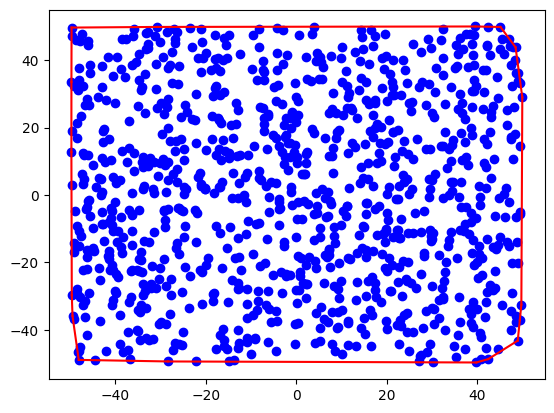

In [392]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')
    
    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')
    
    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)


In [393]:
def segmentos_que_se_cruzam(segmentos):
    eventos = []
    for seg in segmentos:
        if seg.p1.x > seg.p2.x or (seg.p1.x == seg.p2.x and seg.p1.y > seg.p2.y):
            seg.p1, seg.p2 = seg.p2, seg.p1
        eventos.append((seg.p1, 'start', seg))
        eventos.append((seg.p2, 'end', seg))

    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    ordenacao_y = SortedList()
    intersecoes = []

    for ponto, tipo, segmento in eventos:
        if tipo == 'start':
            # Posição onde o segmento será inserido
            idx = ordenacao_y.bisect_left(segmento)
            if idx != 0 and ordenacao_y[idx-1].intersecao(segmento):
                intersecao = (ordenacao_y[idx-1], segmento)
                print(f"Os segmentos {intersecao[0]} e {intersecao[1]} se cruzam.")
                intersecoes.append(intersecao)
            if idx != len(ordenacao_y) and ordenacao_y[idx].intersecao(segmento):
                intersecao = (ordenacao_y[idx], segmento)
                print(f"Os segmentos {intersecao[0]} e {intersecao[1]} se cruzam.")
                intersecoes.append(intersecao)
            ordenacao_y.add(segmento)
        else:
            idx = ordenacao_y.index(segmento)
            if idx != 0 and idx != len(ordenacao_y) - 1 and ordenacao_y[idx-1].intersecao(ordenacao_y[idx+1]):
                intersecao = (ordenacao_y[idx-1], ordenacao_y[idx+1])
                print(f"Os segmentos {intersecao[0]} e {intersecao[1]} se cruzam.")
                intersecoes.append(intersecao)
            ordenacao_y.discard(segmento)

    return intersecoes


def plot_segmentos(segmentos):
    """Plota os segmentos e destaca aqueles que se cruzam."""
    intersecoes = segmentos_que_se_cruzam(segmentos)
    for segmento in segmentos:
        plt.plot([segmento.p1.x, segmento.p2.x], [segmento.p1.y, segmento.p2.y], 'b-')

    for seg1, seg2 in intersecoes:
        plt.plot([seg1.p1.x, seg1.p2.x], [seg1.p1.y, seg1.p2.y], 'b-')
        plt.plot([seg2.p1.x, seg2.p2.x], [seg2.p1.y, seg2.p2.y], 'b-')

    plt.show()

Os segmentos [(1, 10), (10, 1)] e [(5, 5), (8, 5)] se cruzam.


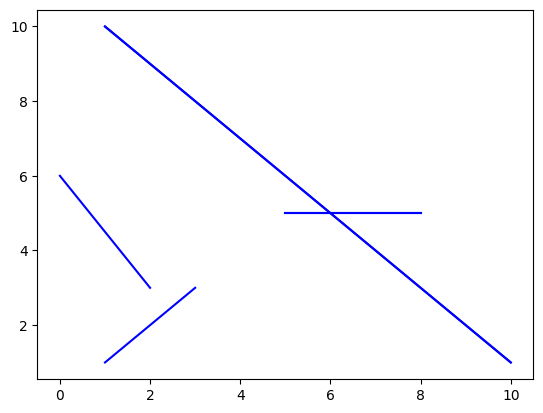

In [394]:
# Exemplo de uso:
s1 = Segmento(Ponto(1, 1), Ponto(3, 3))
s2 = Segmento(Ponto(1, 10), Ponto(10, 1))
s3 = Segmento(Ponto(2, 3), Ponto(0, 6))
s4 = Segmento(Ponto(5, 5), Ponto(8, 5))

segmentos = [s1, s2, s3, s4]
plot_segmentos(segmentos)

Os segmentos [(1, 14), (23, 72)] e [(8, 42), (41, 93)] se cruzam.
Os segmentos [(8, 42), (41, 93)] e [(34, 87), (81, 2)] se cruzam.
Os segmentos [(35, 3), (67, 43)] e [(34, 87), (81, 2)] se cruzam.


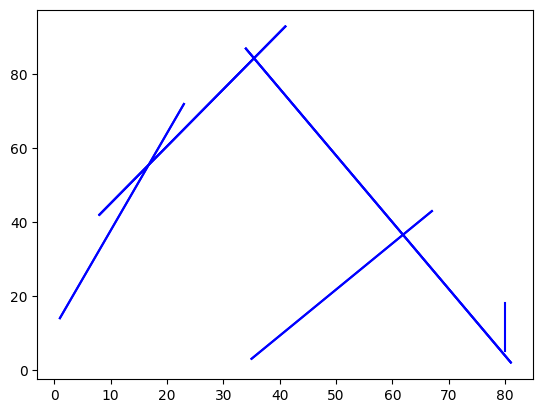

In [429]:
def segmentos_aleatorios(num_segmentos, limite_x, limite_y):
    """Gera uma lista de segmentos aleatórios."""
    segmentos = []
    for _ in range(num_segmentos):
        x1, y1, x2, y2 = random.randint(0, limite_x), random.randint(0, limite_y), random.randint(0, limite_x), random.randint(0, limite_y)
        segmentos.append(Segmento(Ponto(x1, y1), Ponto(x2, y2)))
    return segmentos

# Gerar 10 segmentos aleatórios dentro de uma área de 100x100
segmentos = segmentos_aleatorios(5, 100, 100)
plot_segmentos(segmentos)